In [1]:
import pandas as pd
import numpy as np
import torch 
from fredapi import Fred
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
import mlflow
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
import os
from torch import optim
import torch.nn as nn

In [219]:
batch_size = 4
seq_length = 2
random_seed = 1
torch.manual_seed(random_seed)
log_interval = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_folder = Path("./models")
print(device)

cuda:0


In [124]:
ml_client = MLClient.from_config(DefaultAzureCredential())

Found the config file in: C:\Users\armym\OneDrive\New folder (2)\Documents\ds\config.json


In [125]:
uri = ml_client.workspaces.get("workspace").mlflow_tracking_uri
mlflow.set_tracking_uri(uri)

In [5]:
%%writefile time_series_config.yaml
FRED:
    CPIAUCSL:
        name: CPI
        log: true
        diff: true
        diff_name: log_inflation_MoM
    FEDFUNDS:
        name: fed_rate
        log: true
        diff: true
    UNRATE:
        name: Unemployment
        log: false
        diff: false

Overwriting time_series_config.yaml


In [6]:
path = "./params"
os.makedirs(path, exist_ok=True)

In [144]:
def get_fred_api_key(path):
    with open(path, 'r') as f:
        key = f.read()
        return key

    
def get_data_config(path):
    with open(path, 'r') as f:
        config = yaml.safe_load(f)
        return config
        
config_path = Path("./configs")

key = get_fred_api_key(config_path / "fred_key.txt")
fred = Fred(api_key=key)

configs = get_data_config(config_path / "time_series_config.yaml")
fred_data = configs["FRED"]

def get_data(fred_data):
    data = {fred_data[code].get('name'): fred.get_series_latest_release(code) for code in fred_data}
    df = pd.DataFrame(data)
    return df

data = get_data(fred_data)
print(data.shape)
data.tail()

(926, 3)


,CPI,fed_rate,Unemployment
2023-10-01,307.531,5.33,3.8
2023-11-01,308.024,5.33,3.7
2023-12-01,308.742,5.33,3.7
2024-01-01,309.685,5.33,3.7
2024-02-01,311.054,5.33,3.9


In [145]:
def difference_data(df, config):
    for item in config:
        series = config[item]
        col = series['name']

        try:
            diff_name = series['diff_name'] 
        except Exception:
            diff_name = col + "_diff"
        
        if series['diff'] and series['log']:
            df[diff_name] =  np.log(df[col]).diff()
        elif series['diff']:
            df[diff_name] =  df[col].diff()

    return df.dropna()

data_diff = difference_data(data, fred_data)
print(data_diff.tail())

                CPI  fed_rate  Unemployment  log_inflation_MoM  fed_rate_diff  \
2023-10-01  307.531      5.33           3.8           0.000790            0.0   
2023-11-01  308.024      5.33           3.7           0.001602            0.0   
2023-12-01  308.742      5.33           3.7           0.002328            0.0   
2024-01-01  309.685      5.33           3.7           0.003050            0.0   
2024-02-01  311.054      5.33           3.9           0.004411            0.0   

            Unemployment_diff  
2023-10-01                0.0  
2023-11-01               -0.1  
2023-12-01                0.0  
2024-01-01                0.0  
2024-02-01                0.2  


<Axes: >

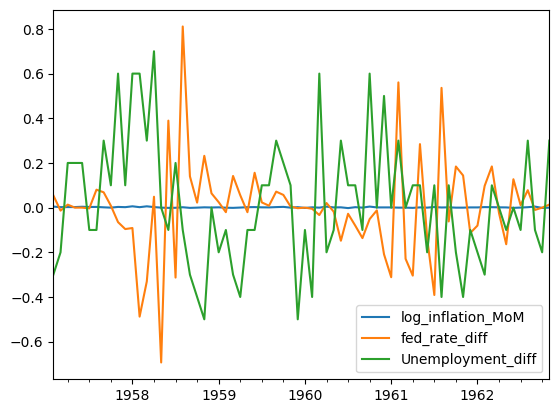

In [146]:
data_diff[["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]].iloc[30:100].plot()

<Axes: >

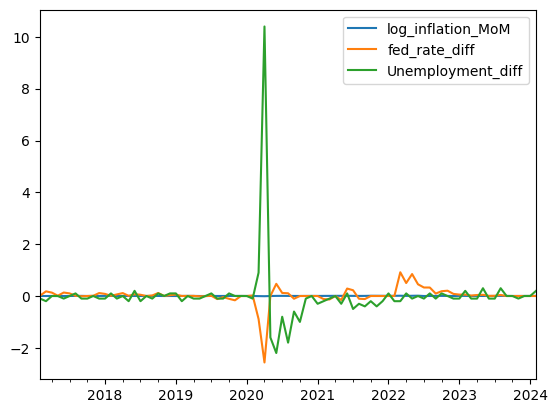

In [148]:
data_diff[["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]].iloc[750:].plot()

In [104]:
data_diff.loc["2020-03-01"]

In [153]:
cutoff = int(data_diff.shape[0]*0.80)
print(cutoff)
validation_cutoff = int(cutoff*0.8)
print(validation_cutoff)

cutoff_date = str(data_diff.iloc[cutoff-1].name)
print("train+validation cutoff",cutoff_date)

validation_cutoff_date = str(data_diff.iloc[validation_cutoff-1].name)
print("validation cutoff", validation_cutoff_date)

668
534
train+validation cutoff 2010-03-01 00:00:00
validation cutoff 1999-01-01 00:00:00


In [220]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

class MonetaryPolicyDataSet(torch.utils.data.Dataset):
    def __init__(self, mode='train', train_end_date=None, 
                 validation_end_date=None, seq_length=3, transform = True):
        """ 
        Input:
            mode: 'train', 'test', 'validation'
        """
        self.data_mode = mode
        assert self.data_mode in ["train", "test", "validation"], "mode can only take on values: [\"train\", \"test\", \"validation\"]"

        self.seq_length = seq_length

        # Get data configs.
        # Includes settings such as differencing the series or taking logs
        configs = get_data_config(config_path / "time_series_config.yaml")
        self.data_dict = configs["FRED"]
        
        
        data = get_data(self.data_dict)
        self.data = difference_data(data, self.data_dict)[["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]]

        self.split_data(train_end_date, validation_end_date)
        
        # Convert to pytorch tensor
        if transform:
            self.data = scaler.transform(self.data)
            self.data = torch.tensor(self.data)
        else:
            self.data = torch.tensor(self.data.values)
        
        
    def __getitem__(self, t):
        return self.data[t: t + self.seq_length], self.data[t + self.seq_length]
    
    
    def __len__(self):
        return len(self.data) - self.seq_length
    

    def split_data(self, train_end_date, validation_end_date):
        if self.data_mode == "train":
            self.data = self.data.loc[:train_end_date]
            scaler.fit(self.data)
            
        elif self.data_mode == "validation":
            # Create  validation set after the train_end_date
            self.data = self.data.loc[pd.to_datetime(train_end_date) + pd.DateOffset(months=1) : validation_end_date]
        
        else:
            # Create test set after the validation_end_date
            assert validation_end_date is not None, "In testing mode, please add validation_end_date"
            self.data = self.data.loc[pd.to_datetime(validation_end_date) + pd.DateOffset(months=1):]


In [221]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def get_data_loaders(train_cutoff, validation_cutoff, seq_length, transform = True):
    # note: validation_cutoff_date is where the train set ends 
    train_dataset = MonetaryPolicyDataSet(
            mode="train", train_end_date=validation_cutoff,
            seq_length = seq_length, transform=transform
        )
    
    validation_dataset = MonetaryPolicyDataSet(
            mode="validation", train_end_date=validation_cutoff,
            validation_end_date= train_cutoff,
            seq_length = seq_length, transform=transform
        )
    
    test_dataset = MonetaryPolicyDataSet(
            mode='test', train_end_date=train_cutoff, 
            validation_end_date= train_cutoff,
            seq_length = seq_length, transform=transform
        )

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_dataloader, validation_dataloader, test_dataloader 

train_dataloader, validation_dataloader, test_dataloader = get_data_loaders(
        train_cutoff=cutoff_date, 
        validation_cutoff=validation_cutoff_date,
        seq_length=seq_length, 
        transform=True,
    )

batch_id, (x, y) = next(enumerate(train_dataloader))
print(x, y)
print(x.size())

tensor([[[-1.2390,  4.1187,  1.0206],
         [-1.6067, -1.3228,  0.5174]],

        [[-1.6067, -1.3228,  0.5174],
         [-2.2221, -2.2965, -1.9988]],

        [[-2.2221, -2.2965, -1.9988],
         [-0.3791, -0.2666, -1.9988]],

        [[-0.3791, -0.2666, -1.9988],
         [-1.2394,  4.2288, -1.4956]]], dtype=torch.float64) tensor([[-2.2221, -2.2965, -1.9988],
        [-0.3791, -0.2666, -1.9988],
        [-1.2394,  4.2288, -1.4956],
        [-1.1166,  0.7786, -0.4891]], dtype=torch.float64)
torch.Size([4, 2, 3])


In [222]:
batch_id, (x, y) = next(enumerate(test_dataloader))
print(x)

tensor([[[-1.0409,  2.1627,  0.0141],
         [-1.2875, -0.0323, -1.4956]],

        [[-1.2875, -0.0323, -1.4956],
         [-1.2543, -1.0687, -0.9923]],

        [[-1.2543, -1.0687, -0.9923],
         [-0.5026, -0.0323,  0.0141]],

        [[-0.5026, -0.0323,  0.0141],
         [-0.6364,  0.4995,  0.5174]]], dtype=torch.float64)


## Baseline Vector Auto Regression

In [263]:
var_train =  pd.DataFrame(train_dataloader.dataset.data, columns=["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]) 

var_test = pd.DataFrame(validation_dataloader.dataset.data, columns=["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"])
print(var_train.tail())
print(var_test.head())

     log_inflation_MoM  fed_rate_diff  Unemployment_diff
529          -0.915417      -0.103493           0.517377
530          -0.313184      -0.850990          -0.489105
531          -0.715613      -0.509366          -0.489105
532          -0.516049      -0.342674           0.014136
533          -0.517144      -0.138000          -0.489105
   log_inflation_MoM  fed_rate_diff  Unemployment_diff
0          -1.116571       0.240045           0.517377
1          -0.917005       0.070446          -0.992345
2           1.070703      -0.176547           0.517377
3          -0.918448      -0.032341          -0.489105
4          -1.116571       0.009076           0.517377


In [213]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

model = VAR(var_train)

In [214]:
order = model.select_order(15)
print(order.summary())
print(order.selected_orders)
order_selection = order.selected_orders['bic']
fit = model.fit(maxlags=order_selection, ic="bic")
fit.summary()

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0      -0.1692     -0.1446      0.8444     -0.1595
1      -0.8717     -0.7734      0.4183     -0.8331
2       -1.062    -0.8903*      0.3456     -0.9950
3       -1.079     -0.8329      0.3400     -0.9824
4       -1.111     -0.7914      0.3293     -0.9858
5       -1.161     -0.7674      0.3133     -1.007*
6       -1.153     -0.6860      0.3157     -0.9700
7       -1.162     -0.6217      0.3128     -0.9506
8       -1.146     -0.5315      0.3180     -0.9052
9       -1.163     -0.4748      0.3126     -0.8934
10     -1.175*     -0.4129     0.3090*     -0.8763
11      -1.171     -0.3353      0.3103     -0.8435
12      -1.167     -0.2579      0.3114     -0.8110
13      -1.165     -0.1821      0.3122     -0.7800
14      -1.144    -0.08745      0.3188     -0.7302
15      -1.154    -0.02349      0.3158     -0.7111
-------------------------------

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 23, Mar, 2024
Time:                     10:06:19
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                  -0.836281
Nobs:                     532.000    HQIC:                 -0.939030
Log likelihood:          -1976.27    FPE:                   0.366011
AIC:                     -1.00510    Det(Omega_mle):        0.351935
--------------------------------------------------------------------
Results for equation log_inflation_MoM
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.003621         0.029940            0.121           0.904
L1.log_inflation_MoM         0.423924         0.040596           10.443           0.000
L1.fed_rate_diff    

In [215]:
forecasts = fit.forecast(var_train.values[-order_selection:], var_test.shape[0])
assert len(forecasts) == var_test.shape[0]

In [216]:
print(len(validation_dataloader.dataset.data))
print(var_test.shape[0])

134
134


In [218]:
forecasts_t = torch.tensor(forecasts)
mse(forecasts_t, validation_dataloader.dataset.data)

tensor(1.4748, dtype=torch.float64)

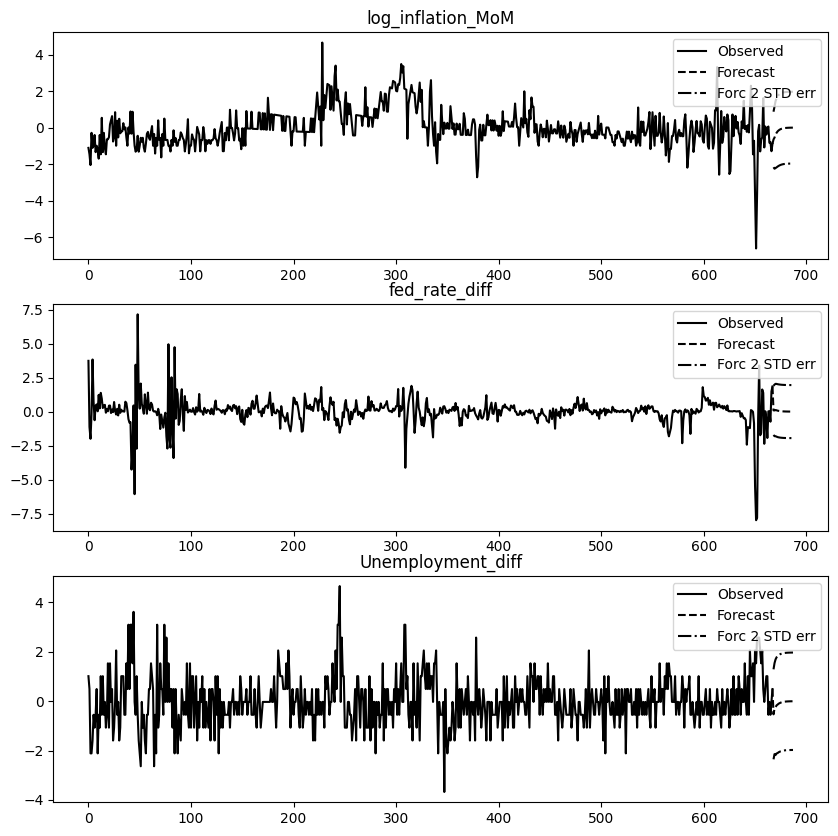

In [82]:
h = fit.plot_forecast(20)

In [223]:
import torch.functional as F
class RNNModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        
        self.recurrent_layer = torch.nn.RNN(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = 1,
            batch_first = True,
            bidirectional = False
        )
        
        self.fc1 = torch.nn.Linear(hidden_size, 3, bias=True)        
        
    def forward(self, x):
        x, hidden = self.recurrent_layer(x)
        x = self.fc1(x[:,-1, :])
        
        return x        

## Test forward

In [224]:
scaled_data = scaler.transform(data_diff[["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]])
scaled_data_df = pd.DataFrame(scaled_data, columns = ["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"], index=data_diff.index)
scaled_data_df = scaled_data_df[scaled_data_df != "2020-04-01"]
scaled_data_df.head()

,log_inflation_MoM,fed_rate_diff,Unemployment_diff
1954-08-01,-1.239001,4.118697,1.020617
1954-09-01,-1.606748,-1.322842,0.517377
1954-10-01,-2.222148,-2.296532,-1.998827
1954-11-01,-0.379107,-0.266560,-1.998827
1954-12-01,-1.239367,4.228821,-1.495586


In [225]:
# Test forward pass
model = RNNModel(3, 20)
torch.manual_seed(1)
test_input = x.float()
print("Input:")
print(test_input.float())
print(test_input.shape)
with torch.no_grad():
    print("Output: ")
    out = model(test_input)
    print(out)
    print("true values:", y.float())

Input:
tensor([[[-1.0409,  2.1627,  0.0141],
         [-1.2875, -0.0323, -1.4956]],

        [[-1.2875, -0.0323, -1.4956],
         [-1.2543, -1.0687, -0.9923]],

        [[-1.2543, -1.0687, -0.9923],
         [-0.5026, -0.0323,  0.0141]],

        [[-0.5026, -0.0323,  0.0141],
         [-0.6364,  0.4995,  0.5174]]])
torch.Size([4, 2, 3])
Output: 
tensor([[-0.1594, -0.2259,  0.0754],
        [-0.1987, -0.0609,  0.1607],
        [-0.2712, -0.0229,  0.1051],
        [-0.2029, -0.0625,  0.0409]])
true values: tensor([[-1.2543, -1.0687, -0.9923],
        [-0.5026, -0.0323,  0.0141],
        [-0.6364,  0.4995,  0.5174],
        [-0.5859, -0.0323,  0.0141]])


In [226]:
mse = nn.MSELoss()
mse(model(test_input), y)

tensor(0.3240, dtype=torch.float64, grad_fn=<MseLossBackward0>)

## Train RNN

In [227]:
from torch import optim
import torch.nn as nn

class RNN:
    def __init__(self, rnn, model_name, n_epoch:int, 
                 train_loader, validation_loader, 
                 learning_rate:float=0.0001, gradient_clipping=None,
                 device = None, train_data_end_date = None,
                ):
        self.n_epoch, self.lr, self.graident_clip = n_epoch, learning_rate, gradient_clipping

        self.train_loader, self.validation_loader = train_loader, validation_loader
        
        self.net = rnn
        self.model_name = model_name
        
        self.optimizer = optim.Adam(
                lr=self.lr, 
                params=self.net.parameters()
            ) 
        
        # Mean squared error loss
        self.loss = nn.MSELoss()

        self.best_validation_loss = 1000000
        self.best_model = None
        self.device = device
        
        self.train_data_end_date = train_data_end_date

        
    def train(self):
        with mlflow.start_run() as run:
            self.run = run
            self.log_params()
            
            self.train_error = []
            self.val_error = []
            for epoch in range(1, self.n_epoch + 1):
                self.train_loop(epoch)
                self.validation(epoch)
            self.log_loss()
            self.log_model(self.best_validation_loss)
            mlflow.log_metric("Best-validation-loss", self.best_validation_loss)

        
    def train_loop(self, epoch):
        losses = []
        self.net.train()
        for idx, (x, y) in enumerate(self.train_loader):
            
            x = x.to(self.device).float()
            y = y.to(self.device).float()

            # Calculate losses and optimize 
            self.optimizer.zero_grad()
            output = self.net(x)
            loss = self.loss(output, y)
            losses.append(loss.item())
            loss.backward()

            if self.graident_clip:
                nn.utils.clip_grad_norm_(self.net.parameters(), self.graident_clip)

            self.optimizer.step()

            if idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, idx * len(x), len(self.train_loader.dataset),
                100. * idx / len(self.train_loader), loss.item()))
                
        
        # if epoch % 10 == 0:
        #     with torch.no_grad():
        #         for i, param in enumerate(self.net.parameters()):
        #             p = param.cpu().numpy()
        #             df = pd.DataFrame(p)
        #             df.to_csv(f"./params/params_{i}.csv")
        #         mlflow.log_artifacts("./params", f"./params/{epoch}")
        
        avg_loss = np.mean(losses)
        self.train_error.append(avg_loss)
        print("Epoch {} average train loss: {:.6f}".format(epoch, avg_loss))

    
    def validation(self, epoch):
        losses = []
        for idx, (x, y) in enumerate(self.validation_loader):
            x = x.to(self.device).float()
            y = y.to(self.device).float()
            
            self.net.eval()
            with torch.no_grad():
                validation_output = self.net(x)#.reshape(-1,3)
                loss_val = self.loss(validation_output, y)
                losses.append(loss_val.item())
                
        avg_loss = np.mean(losses)

        # Track the best model and validation loss
        if avg_loss < self.best_validation_loss:
            self.best_validation_loss = avg_loss
            torch.save(self.net, model_folder / f"{self.model_name}.pt")
            

        self.val_error.append(avg_loss)
        print("Epoch {} average validation loss: {:.6f}".format(epoch, avg_loss))
    
    
    def log_params(self):
        mlflow.log_params(
            {
                "batch size": batch_size,
                "epochs": self.n_epoch,
                "sequence length": seq_length,
                "learning_rate": self.lr,
                "hidden size": self.net.hidden_size,
                "optimizer": self.optimizer,
                "gradient clipping": self.graident_clip

            }
        )

        # Log  data size
        mlflow.log_param("Train data end", self.train_data_end_date)
        mlflow.log_param("Train data size", len(train_dataloader.dataset))
        mlflow.log_param("Validation data size", len(test_dataloader.dataset))


    def log_model(self, loss):
        print("Saving best model with lowest validation mse loss = {}".format(loss))        
        best_model = torch.load(model_folder / f"{self.model_name}.pt")
        best_model.eval()
        mlflow.pytorch.log_model(best_model, "best_model")


    def log_loss(self):
        log_every = 10
        for epoch, val in enumerate(self.train_error):
            if epoch % log_every == 0:
                mlflow.log_metric(f"train mean loss", val, step=epoch)
            
        for epoch, val in enumerate(self.val_error):
            if epoch % log_every == 0:
                mlflow.log_metric(f"val-loss", val, step=epoch)

    
    def predict(self, x):
        with torch.no_grad():
            return self.net(x.to(self.device).float())
            
            
    def load_model(self, path):
        self.net = torch.load(path)

In [228]:
# Set the training experiment
mlflow.set_experiment('MonetaryPolicyRNN')
hidden_size = 16

# Initialize model
model = RNNModel(3, hidden_size).to(device)
rnn = RNN(model, "RNN", 120, train_dataloader, validation_dataloader, 
          learning_rate=0.0001, device=device, train_data_end_date=cutoff_date)
# Train
rnn.train()

Train Epoch: 1 [0/532 (0%)]	Loss: 3.476465
Train Epoch: 1 [400/532 (75%)]	Loss: 0.425899
Epoch 1 average train loss: 1.077679
Epoch 1 average validation loss: 1.462900
Train Epoch: 2 [0/532 (0%)]	Loss: 3.420128
Train Epoch: 2 [400/532 (75%)]	Loss: 0.417633
Epoch 2 average train loss: 1.049198
Epoch 2 average validation loss: 1.450031
Train Epoch: 3 [0/532 (0%)]	Loss: 3.377675
Train Epoch: 3 [400/532 (75%)]	Loss: 0.411699
Epoch 3 average train loss: 1.024121
Epoch 3 average validation loss: 1.439800
Train Epoch: 4 [0/532 (0%)]	Loss: 3.336031
Train Epoch: 4 [400/532 (75%)]	Loss: 0.407555
Epoch 4 average train loss: 1.002077
Epoch 4 average validation loss: 1.431671
Train Epoch: 5 [0/532 (0%)]	Loss: 3.295056
Train Epoch: 5 [400/532 (75%)]	Loss: 0.404744
Epoch 5 average train loss: 0.982558
Epoch 5 average validation loss: 1.425201
Train Epoch: 6 [0/532 (0%)]	Loss: 3.254492
Train Epoch: 6 [400/532 (75%)]	Loss: 0.402920
Epoch 6 average train loss: 0.965094
Epoch 6 average validation loss: 1

2024/03/23 10:09:45 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saving best model with lowest validation mse loss = 1.3831127446257707


2024/03/23 10:09:51 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.10.0, required: mlflow==2.11.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


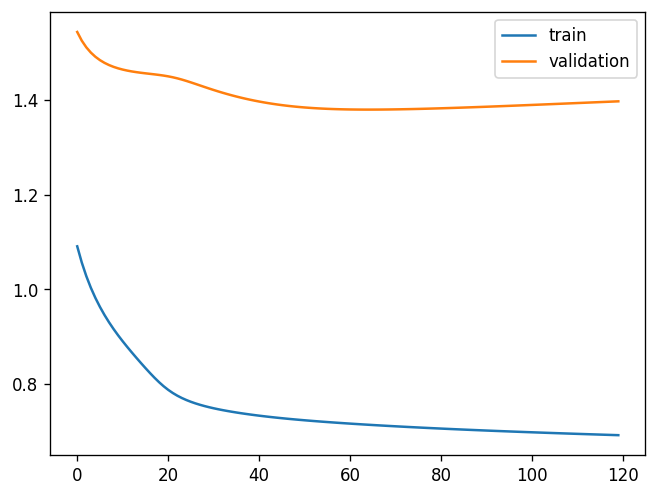

In [190]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=120)

ax.plot(np.arange(len(rnn.train_error)), rnn.train_error, label='train')
ax.plot(np.arange(len(rnn.val_error)), rnn.val_error, label='validation')
plt.legend()

## Look at some of the fitted values

In [191]:
means = scaler.mean_
standard_devs = np.sqrt(scaler.var_)

In [192]:
rnn.load_model("./models/RNN.pt")

In [193]:
def get_predictions(model, loader, return_residuals = False):
    mse = nn.MSELoss(reduction="none")
    predictions = []
    residuals = []
    for idx, (x, y) in enumerate(loader):
        pred = model.predict(x)
        predictions.append(pred)
        
        res = pred-y.to(device)
        residuals.append(res)
        
    predictions_concat = torch.concat(predictions, dim=0).cpu().numpy()
    residuals_concat = torch.concat(residuals, dim=0).cpu().numpy()
    if return_residuals:
        return predictions_concat, residuals_concat
    else:
        return predictions_concat

In [194]:

def plot_predictions(model, range_:list, loader, transform = False):
    predictions = get_predictions(model, loader)
    
    # If we are testing we need to start the index at the cutoff for when we concatinate predictions 
    # with the actual values
    
    predictions_df = pd.DataFrame(
        predictions, 
        columns = ["log_inflation_MoM_pred", "fed_rate_diff_pred", "Unemployment_diff_pred"], 
    )

    fig, axs = plt.subplots(3, dpi=120, figsize=(14, 10))
    all_data = pd.concat([pd.DataFrame(loader.dataset.data, columns=["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]), predictions_df], 
                         ignore_index=False, axis=1)

    if transform:
        (all_data[["log_inflation_MoM_pred", "log_inflation_MoM"]]*standard_devs[0] + means[0]).iloc[range_[0]:range_[1]].plot(ax=axs[0])
        (all_data[["fed_rate_diff_pred", "fed_rate_diff"]]*standard_devs[1] + means[1]).iloc[range_[0]:range_[1]].plot(ax=axs[1])
        (all_data[["Unemployment_diff_pred", "Unemployment_diff"]]*standard_devs[2] + means[2]).iloc[range_[0]:range_[1]].plot(ax=axs[2])
    else:
        (all_data[["log_inflation_MoM_pred", "log_inflation_MoM"]]).iloc[range_[0]:range_[1]].plot(ax=axs[0])
        (all_data[["fed_rate_diff_pred", "fed_rate_diff"]]).iloc[range_[0]:range_[1]].plot(ax=axs[1])
        (all_data[["Unemployment_diff_pred", "Unemployment_diff"]]).iloc[range_[0]:range_[1]].plot(ax=axs[2])

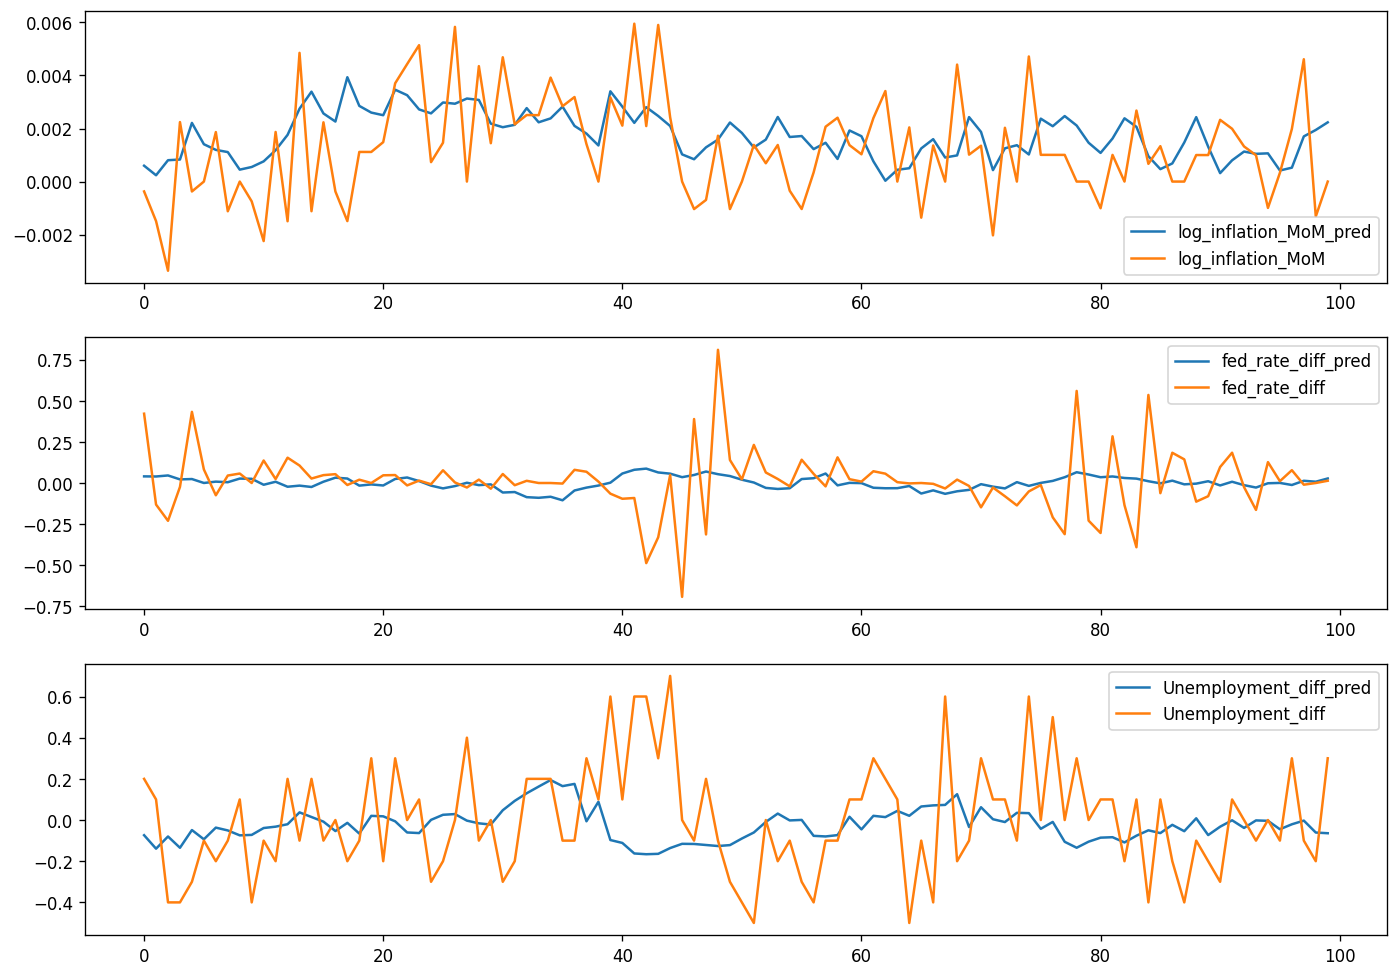

In [195]:
plot_predictions(rnn, [0, 100], train_dataloader, transform=True)

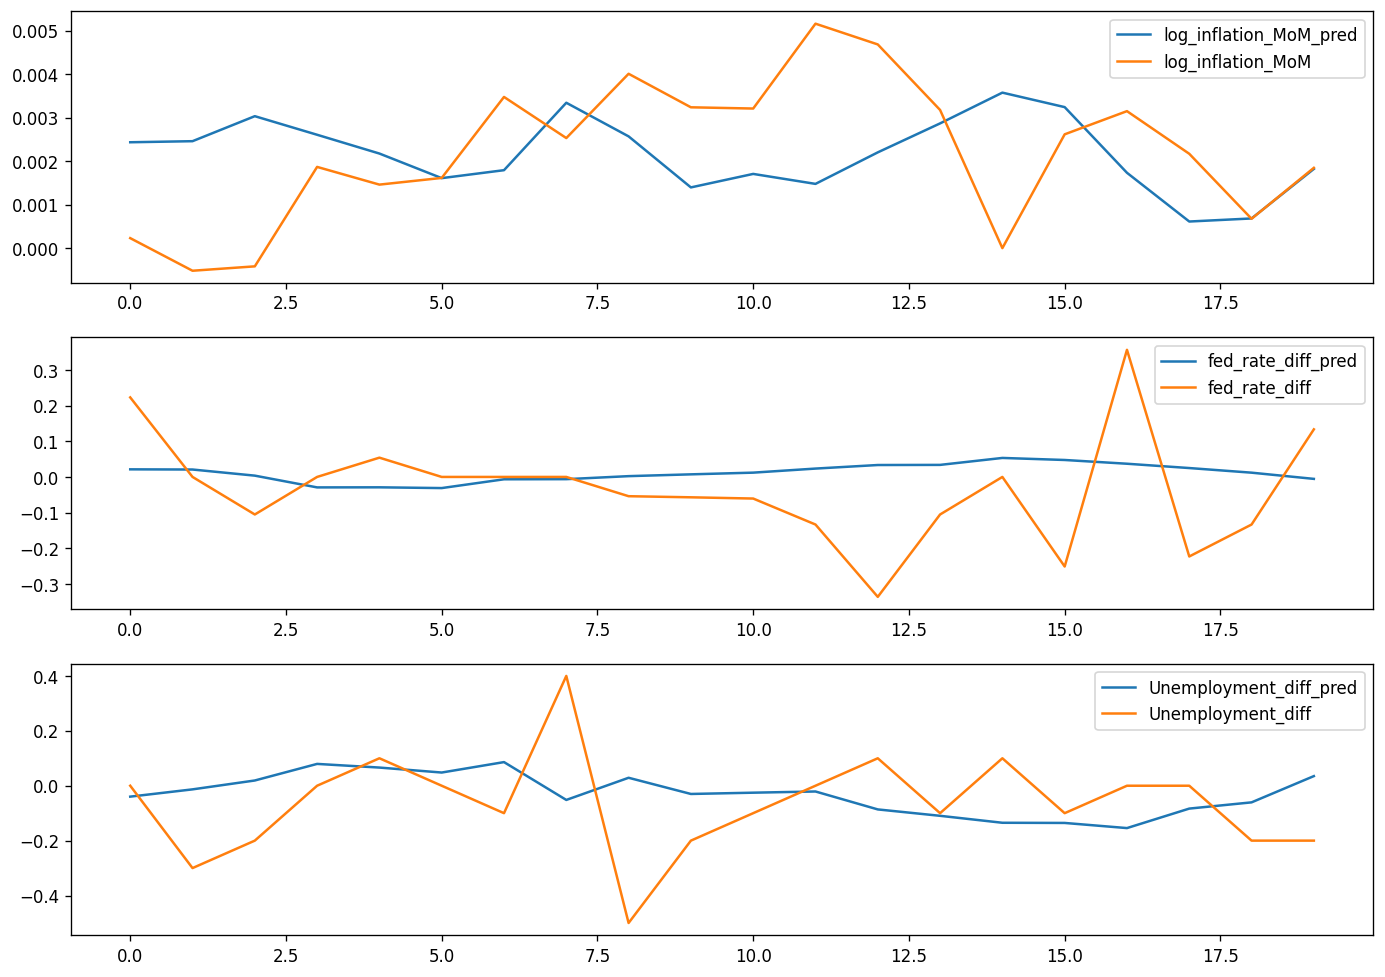

In [196]:
plot_predictions(rnn, [0, 20], test_dataloader, transform=True)

## Check that residuals are white noise

Text(0.5, 1.0, 'Unemployment_DIFF_pred Residuals')

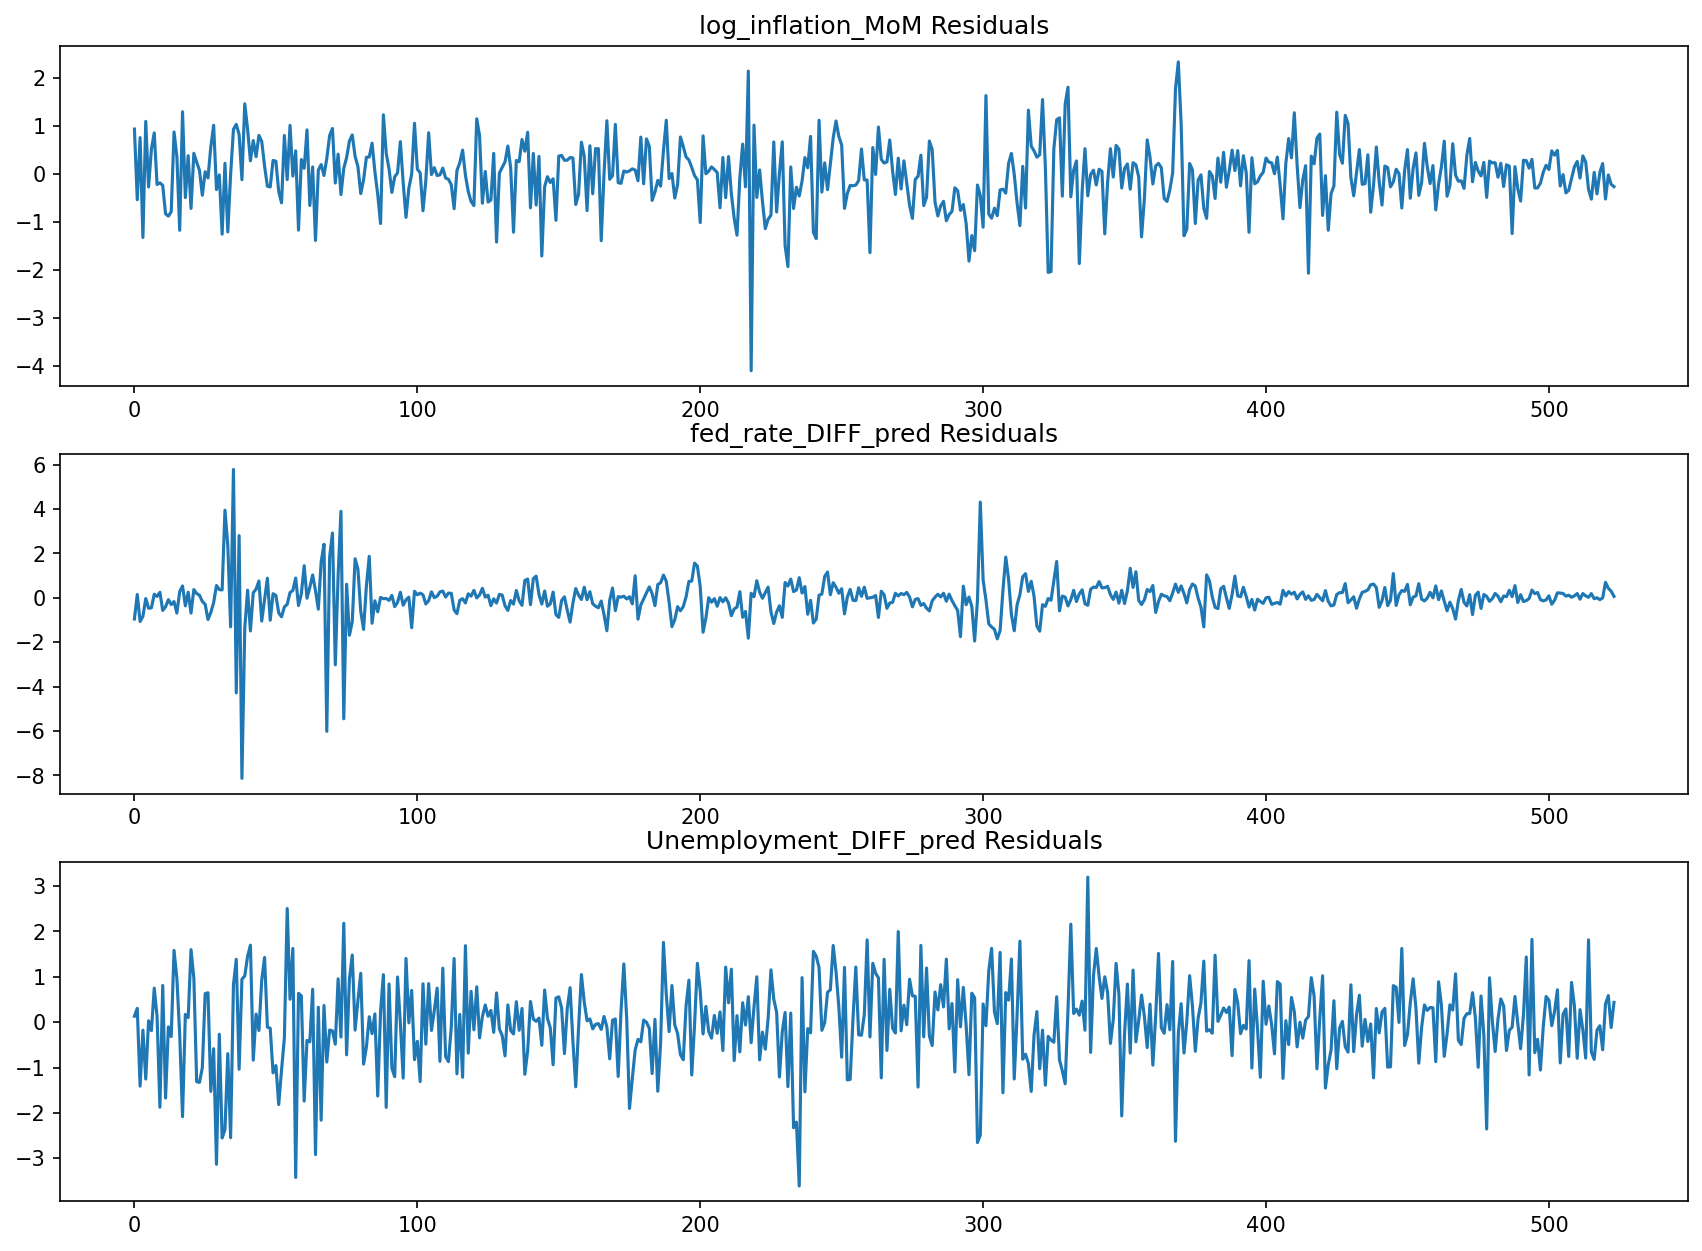

In [197]:
pred, res = get_predictions(rnn, train_dataloader,return_residuals=True)
residuals_df = pd.DataFrame(
        res, 
        columns = ["log_inflation_MoM_pred_res", "fed_rate_DIFF_pred_res", "Unemployment_DIFF_pred_res"]
    )

fig, axs = plt.subplots(3, dpi=150, figsize=(14, 10))

residuals_df["log_inflation_MoM_pred_res"].plot(ax=axs[0])
residuals_df["fed_rate_DIFF_pred_res"].plot(ax=axs[1])
residuals_df["Unemployment_DIFF_pred_res"].plot(ax=axs[2])
axs[0].set_title("log_inflation_MoM Residuals")
axs[1].set_title("fed_rate_DIFF_pred Residuals")
axs[2].set_title("Unemployment_DIFF_pred Residuals")

----

# LSTM With Pytorch

----

## Input gate, output gate, and forget gate
$I = \sigma(\mathbf{X}_t\mathbf{W}_{xi} + \mathbf{H}_{t-1}\mathbf{W}_{hi} + \mathbf{b}_{i}) \\ $ 
$O = \sigma(\mathbf{X}_t\mathbf{W}_{xo} + \mathbf{H}_{t-1}\mathbf{W}_{ho} + \mathbf{b}_{o}) \\ $
$F = \sigma(\mathbf{X}_t\mathbf{W}_{xf} + \mathbf{H}_{t-1}\mathbf{W}_{hf} + \mathbf{b}_{f})$

In [198]:
class Gate(nn.Module):
    def __init__(self, input_size, hidden_size, activation = "sigmoid"):
        super(Gate, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Params for input gate
        self.W_xi = nn.Parameter(
            torch.randn(input_size, hidden_size),
        )
        
        self.W_hi = nn.Parameter(
            torch.randn(hidden_size, hidden_size),
        )
         
        self.b_i = nn.Parameter(
            torch.zeros(hidden_size),     
        )
        
        
        self.activation = nn.Tanh() if activation == "tanh" else nn.Sigmoid()

        self.initialize_params()


    def initialize_params(self):
        a = np.sqrt(1/self.hidden_size)
        for param in self.parameters():
            param.data.uniform_(-a, a)
        
    
    def forward(self, X, old_state = None):
        if old_state is None:
            # Initiallize hidden state
            old_state = torch.zeros((X.shape[0], self.hidden_size),
                          device=X.device)   

        return self.activation(torch.matmul(X, self.W_xi) + 
                              torch.matmul(old_state, self.W_hi) + self.b_i) 

In [199]:
# Test the input gate forward pass
I = Gate(3, 5).to(device)
with torch.no_grad():
    print(x[0].shape)
    print(I(x[0].to(device).float()))

torch.Size([10, 3])
tensor([[0.4200, 0.6819, 0.8433, 0.1077, 0.3146],
        [0.7124, 0.6215, 0.3315, 0.4669, 0.3830],
        [0.5614, 0.4204, 0.2024, 0.6464, 0.3706],
        [0.3032, 0.4389, 0.3257, 0.5423, 0.5027],
        [0.1912, 0.4946, 0.8029, 0.1587, 0.3357],
        [0.4503, 0.5574, 0.5047, 0.3518, 0.3985],
        [0.4419, 0.5143, 0.3104, 0.5335, 0.4902],
        [0.5015, 0.5539, 0.4771, 0.3683, 0.3722],
        [0.5738, 0.6320, 0.5107, 0.3278, 0.3930],
        [0.3592, 0.4351, 0.3780, 0.4827, 0.4064]], device='cuda:0')


In [200]:
class MemoryCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MemoryCell, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.I = Gate(self.input_size, self.hidden_size)
        self.F = Gate(self.input_size, self.hidden_size)
        self.O = Gate(self.input_size, self.hidden_size)
        
        self.input_node = Gate(self.input_size, self.hidden_size, activation='tanh')
        
        self.tanh = nn.Tanh()
    
    
    def forward(self, X, state = None, internal_state = None):
        if state is None:
            state = torch.zeros((X.shape[1], self.hidden_size),
                          device=X.device)    
        if internal_state is None:
            internal_state = torch.zeros((X.shape[1], self.hidden_size),
                          device=X.device)  
            
        outputs = []
        for x in X:
            I = self.I(x, state)
            F = self.F(x, state)
            O = self.O(x, state)
            input_ = self.input_node(x, state)
            internal_state = F * internal_state + I * input_
            state = O * torch.tanh(internal_state)
            outputs.append(state)
            
        try:
            h = torch.stack(outputs, 0)
        except Exception as e:
            print(e)
            print("shape:", X.shape)
            print("outputs:", outputs)
        else:
            return h, (state, internal_state)

In [229]:
# Test forward
torch.manual_seed(1)
memory = MemoryCell(3, 5).to(device)
with torch.no_grad():
    o, _ = memory(x.to(device).float())
    print(o)

tensor([[[-4.1440e-05,  2.2524e-01, -5.3905e-02, -5.1518e-02, -2.5937e-02],
         [ 1.1946e-02,  1.4739e-01, -7.9746e-02,  4.0804e-02, -4.8786e-02]],

        [[ 3.5868e-02,  2.4664e-01, -1.1987e-01, -2.9510e-03, -5.0738e-02],
         [ 4.6052e-03,  1.4499e-01, -1.6726e-01,  1.3749e-01, -6.0953e-02]],

        [[ 3.8004e-02,  1.8309e-01, -1.9396e-01,  1.0067e-01, -5.8610e-02],
         [-3.8834e-02,  1.2996e-01, -1.8698e-01,  1.2635e-01, -4.7331e-02]],

        [[-1.6114e-02,  1.3973e-01, -2.0104e-01,  9.9740e-02, -3.9543e-02],
         [-5.0488e-02,  1.8175e-01, -1.9134e-01,  6.6194e-02, -1.2565e-02]]],
       device='cuda:0')


In [252]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        
        #self.memory = MemoryCell(input_size, hidden_size)
        self.memory = nn.LSTM(input_size, hidden_size)
        
        self.fc1 = nn.Linear(hidden_size, 3)
    
    def forward(self, X):
        x, (h, c) = self.memory(X)
        return self.fc1(x[:, -1, :]), h
        

In [259]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        
        self.memory = MemoryCell(input_size, hidden_size)
        
        self.fc1 = nn.Linear(hidden_size, 3)
    
    def forward(self, X):
        x, (h, c) = self.memory(X)
        return self.fc1(x[:, -1, :])

In [260]:
# Test forward
#torch.manual_seed(1)
lstm = LSTM(3, 16)
with torch.no_grad():
    o = lstm(x.float())
    print(o)

tensor([[-0.0182, -0.0612,  0.2422],
        [-0.0421, -0.0856,  0.2278],
        [-0.0354, -0.0849,  0.1985],
        [-0.0206, -0.1037,  0.1910]])


### Train LSTM

In [262]:
hidden_size = 16
seq_length = 10
train_dataloader, validation, test_dataloader = get_data_loaders(cutoff_date, validation_cutoff_date, seq_length, transform=True)

lstm = LSTM(3, hidden_size).to(device)
lstm_model = RNN(lstm, "LSTM", 120, train_dataloader, validation_dataloader, 
                 learning_rate=0.0001, device=device, train_data_end_date=cutoff_date)

mlflow.set_experiment('LSTM_training')
# Train LSTM
lstm_model.train()

Train Epoch: 1 [0/524 (0%)]	Loss: 1.358404
Train Epoch: 1 [400/524 (76%)]	Loss: 0.115171
Epoch 1 average train loss: 0.992889
Epoch 1 average validation loss: 1.453751
Train Epoch: 2 [0/524 (0%)]	Loss: 1.336717
Train Epoch: 2 [400/524 (76%)]	Loss: 0.112484
Epoch 2 average train loss: 0.985973
Epoch 2 average validation loss: 1.450767
Train Epoch: 3 [0/524 (0%)]	Loss: 1.316766
Train Epoch: 3 [400/524 (76%)]	Loss: 0.109838
Epoch 3 average train loss: 0.979004
Epoch 3 average validation loss: 1.447809
Train Epoch: 4 [0/524 (0%)]	Loss: 1.296905
Train Epoch: 4 [400/524 (76%)]	Loss: 0.107279
Epoch 4 average train loss: 0.972064
Epoch 4 average validation loss: 1.444882
Train Epoch: 5 [0/524 (0%)]	Loss: 1.277297
Train Epoch: 5 [400/524 (76%)]	Loss: 0.104817
Epoch 5 average train loss: 0.965171
Epoch 5 average validation loss: 1.441988
Train Epoch: 6 [0/524 (0%)]	Loss: 1.257991
Train Epoch: 6 [400/524 (76%)]	Loss: 0.102458
Epoch 6 average train loss: 0.958318
Epoch 6 average validation loss: 1

2024/03/23 10:41:53 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saving best model with lowest validation mse loss = 1.3878560246843281


2024/03/23 10:41:58 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.10.0, required: mlflow==2.11.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


In [264]:
# Get experiments sorted by best validations score
client = mlflow.MlflowClient() 
exp = mlflow.get_experiment_by_name('LSTM_training')
runs = mlflow.search_runs(exp.experiment_id)
runs = runs[runs['status'] != "FAILED"]
runs.sort_values(by="metrics.Best validation loss").head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train mean loss,metrics.val loss,metrics.Best validation loss,metrics.Best-validation-loss,...,params.sequence length,params.hidden size,params.learning_rate,params.Train data size,params.Train data end,params.Validation data size,params.gradient clipping,tags.mlflow.rootRunId,tags.mlflow.user,tags.mlflow.runName
18,96335e53-d488-421d-8c0b-5c2a48053f80,536bf77d-2a14-4df7-9772-a61c8dfa01e7,FINISHED,,2024-03-22 21:47:59.765000+00:00,2024-03-22 21:51:58.249000+00:00,0.773501,1.980380,1.979774,NaN,...,2,16,0.0001,666,2010-03-01 00:00:00,164,1,96335e53-d488-421d-8c0b-5c2a48053f80,Garett Kaube,willing_circle_f8ryf8rr
17,d31f2e84-615f-4dd9-baa0-64b3fc61000e,536bf77d-2a14-4df7-9772-a61c8dfa01e7,FINISHED,,2024-03-22 00:43:19.152000+00:00,2024-03-22 00:46:51.011000+00:00,0.509793,2.972246,2.941829,NaN,...,100,32,0.0001,None,None,None,None,d31f2e84-615f-4dd9-baa0-64b3fc61000e,Garett Kaube,sincere_town_47zxrs2y
2,906e2f9e-50a0-4316-be47-a6167870e83b,536bf77d-2a14-4df7-9772-a61c8dfa01e7,FINISHED,,2024-03-21 13:56:05.819000+00:00,2024-03-21 14:01:04.113000+00:00,0.755244,2.408690,NaN,NaN,...,2,16,0.0001,None,None,None,None,906e2f9e-50a0-4316-be47-a6167870e83b,Garett Kaube,busy_deer_cqs39k28
3,f61909b7-5b93-4fd3-9299-1eb9bdc918c4,536bf77d-2a14-4df7-9772-a61c8dfa01e7,FINISHED,,2024-03-21 14:13:15.267000+00:00,2024-03-21 14:18:07.329000+00:00,0.792586,2.553793,NaN,NaN,...,2,16,0.0001,None,None,None,None,f61909b7-5b93-4fd3-9299-1eb9bdc918c4,Garett Kaube,jovial_cord_3j5z6qm8
4,7e8e4bac-3d42-423a-9cc4-aa370bfa70d9,536bf77d-2a14-4df7-9772-a61c8dfa01e7,FINISHED,,2024-03-21 14:21:21.750000+00:00,2024-03-21 14:28:03.638000+00:00,0.705775,2.533694,NaN,NaN,...,2,16,0.0001,None,None,None,None,7e8e4bac-3d42-423a-9cc4-aa370bfa70d9,Garett Kaube,silly_yuca_2q6c7hcm


In [265]:
# Load saved best model
lstm_model.load_model("./models/LSTM.pt")

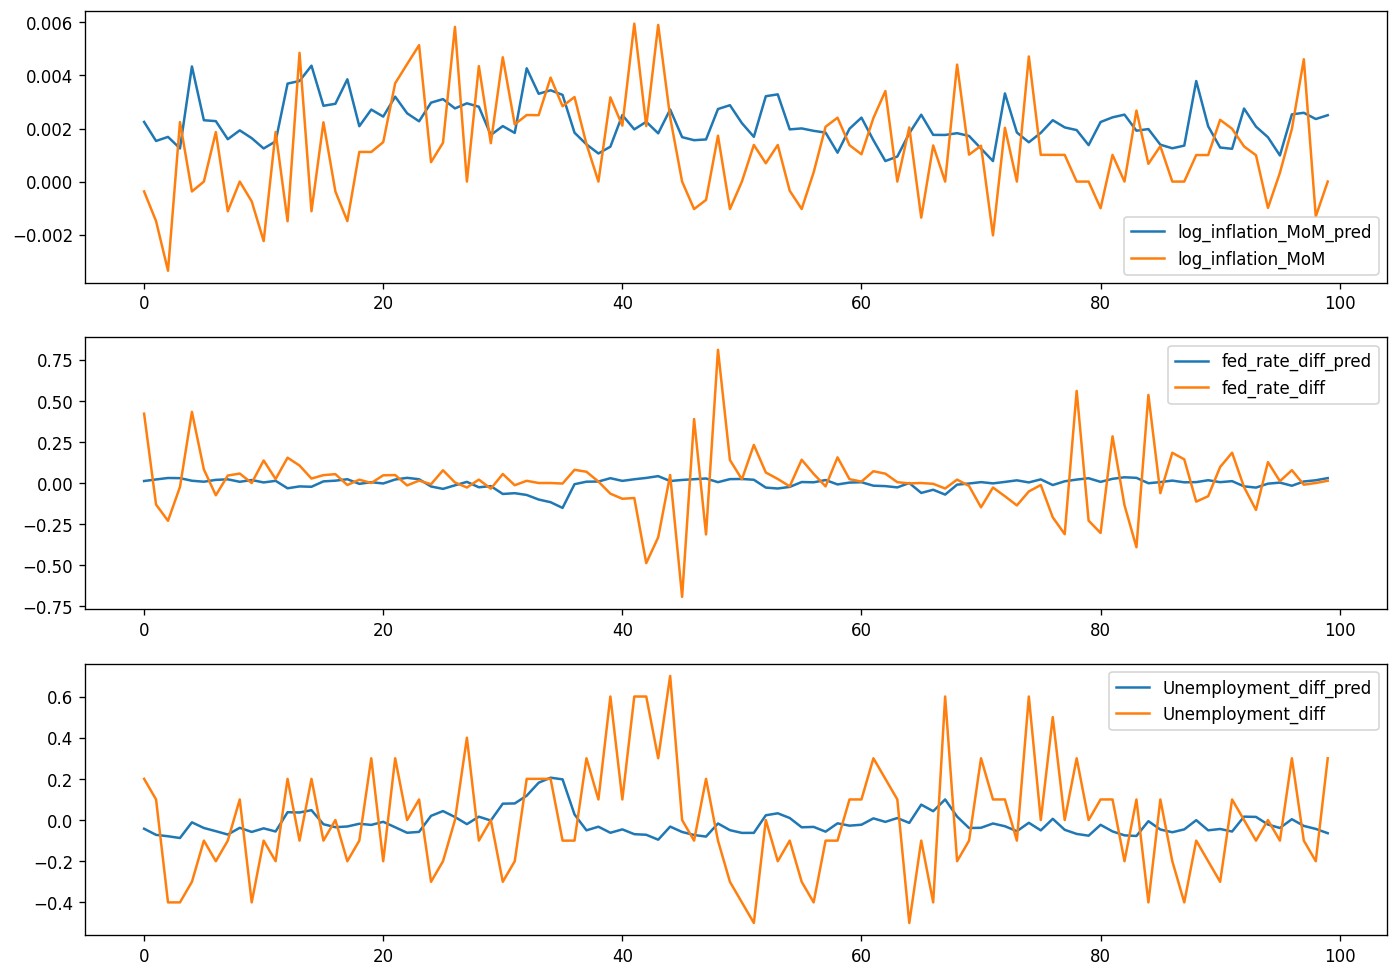

In [266]:
plot_predictions(lstm_model, [0, 100], train_dataloader, transform=True)

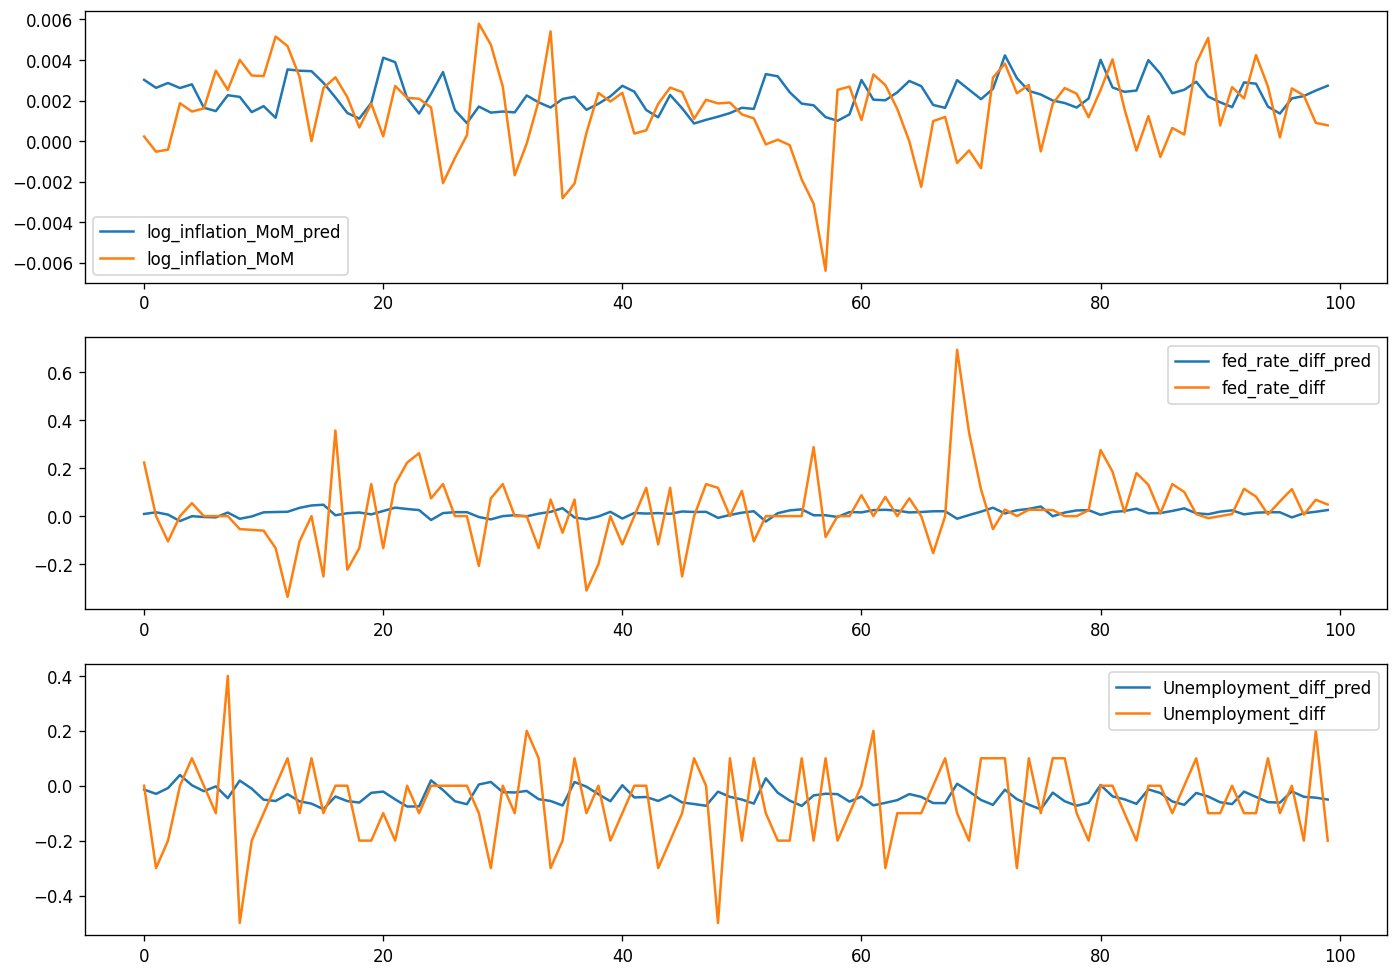

In [267]:
plot_predictions(lstm_model, [0,100], test_dataloader, transform=True)